In [1]:
from cv2 import aruco
import cv2
import numpy as np
import matplotlib.pyplot as plt
import msgpack as mp
import msgpack_numpy as mpn
import os
from tqdm import tqdm
import csv
import pandas as pd
import polars as pl
import sys

sys.path.append(os.path.join(os.getcwd(), ".."))
from support.pd_support import *

from datetime import datetime

from support.pd_support import *
from support.ar_calculations import *

from scipy.signal import savgol_filter
from scipy import integrate
from ahrs.filters import Madgwick

sys.path.append("..")
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "frameworks", "dtag"))

from datetime import datetime

dtag_rep_pth = os.path.dirname(os.getcwd())
dtag_rep_pth = os.path.join(dtag_rep_pth, "frameworks", "dtag")
import json
from scipy import stats


import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

pio.renderers.default = "vscode"
import toml

In [2]:
# _pth = os.getcwd()
# _pth = os.path.dirname(_pth)

_pth = toml.load("DATA_PATH.toml")["data_path"]["directory"]
_pth = os.path.dirname(_pth)
_parent_folder = "validation"
_calib_folder_name = "calibration_charuco"

# _folder_name = "ar_30_5_quad_random_slow_01"
_folder_name = "skimu5_30_5_random_5m_0"
# _folder_name = "board"

_base_pth = os.path.join(_pth, "recorded_data", _parent_folder)

_webcam_calib_folder = os.path.join(
    _pth, "recorded_data", _parent_folder, _calib_folder_name
)
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join(_webcam_calib_folder, "webcam_calibration.msgpack")

with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

ar_lframe_pth = os.path.join(
    _webcam_calib_folder, "charuco_rotmat_validation_imu_6.msgpack"
)
with open(ar_lframe_pth, "rb") as f:
    ar_lframe = mp.Unpacker(f, object_hook=mpn.decode)
    _ar_lframe_rot = next(ar_lframe)
    _ar_lframe_org = next(ar_lframe)


config_filename = f"{dtag_rep_pth}\\config_video.json"
config_dict = json.load(open(config_filename, "r"))
# cameraMatrix = _webcam_8_point_mat[0]
cameraMatrix = _webcam_cam_mat.reshape(1, 9)[0]
# distCoeffs = _webcam_8_point_dist[0][:8]
distCoeffs = _webcam_dist[0]
tag_real_size_in_meter = 0.04
is_video = config_dict["is_video"] != 0
filename = config_dict["filepath"]
tag_family = config_dict["family"]
codebook_filename = (
    config_dict["codebook"]
    if len(config_dict["codebook"])
    else os.path.join("codebook", tag_family + "_codebook.txt")
)
hamming_dist = config_dict["hamming_dist"]
load_config_flag = True

In [3]:
_om = get_rb_marker_name(3)
_xm = get_rb_marker_name(2)
_zm = get_rb_marker_name(1)

In [4]:
from deeptag_model_setting import load_deeptag_models
from marker_dict_setting import load_marker_codebook
from stag_decode.detection_engine import DetectionEngine

In [5]:
timeoffset = 0.0
_imu_pth = os.path.join(_base_pth, _folder_name, "imu01.csv")
_imu_df = pl.read_csv(_imu_pth)

dt = _imu_df["mils"].diff().mean() / 1000
dt = 0.01
filter_size = 101
filter_order = 9
_mean_gx = _imu_df["gx"][:filter_size].mean()
_mean_gy = _imu_df["gy"][:filter_size].mean()
_mean_gz = _imu_df["gz"][:filter_size].mean()
_mean_ax = _imu_df["ax"][:filter_size].mean()
_mean_ay = _imu_df["ay"][:filter_size].mean()
_mean_az = _imu_df["az"][:filter_size].mean()

# subtracting mean from gyro
_imu_df = _imu_df.with_columns(
    [
        (pl.col("gx") - _mean_gx).alias("gx"),
        (pl.col("gy") - _mean_gy).alias("gy"),
        (pl.col("gz") - _mean_gz).alias("gz"),
    ]
)

# subtracting mean from accel
_imu_df = _imu_df.with_columns(
    [
        (pl.col("ax") - _mean_ax).alias("ax"),
        (pl.col("ay") - _mean_ay).alias("ay"),
        (pl.col("az") - _mean_az).alias("az"),
    ]
)

# apply savgol filter
_imu_df = _imu_df.with_columns(
    [
        pl.col("ax")
        .map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order))
        .explode(),
        pl.col("ay")
        .map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order))
        .explode(),
        pl.col("az")
        .map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order))
        .explode(),
    ]
)

_imu_df = _imu_df.with_columns(
    [
        (pl.col("gx").cumsum() * dt * 9.81).alias("ang_x"),
        (pl.col("gy").cumsum() * dt * 9.81).alias("ang_y"),
        (pl.col("gz").cumsum() * dt * 9.81).alias("ang_z"),
    ]
)

_imu_df = _imu_df.with_columns(pl.col("sys_time").str.to_datetime().alias("time"))
_imu_df = _imu_df.with_columns(
    pl.col("time").map(lambda x: x + timedelta(seconds=timeoffset)).alias("time")
)

# change string to float
_imu_df = _imu_df.with_columns(
    pl.col("mz\r").str.replace("\r", "").cast(pl.Float64).alias("mz")
)

In [6]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_MIP_36H12)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = int(_folder_name.split("_")[2]) / 100
markerSeperation = 0.01

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)

In [7]:
# timestamp
ts = []
ts_pth = os.path.join(_base_pth, _folder_name, "webcam_timestamp.msgpack")
ts_file = open(ts_pth, "rb")
ts_unpacker = mp.Unpacker(ts_file, object_hook=mpn.decode)
for ts_data in ts_unpacker:
    ts.append(ts_data)

In [8]:
def estimatePoseSingleMarkers(corners, marker_points, mtx, distortion):
    trash = []
    rvecs = []
    tvecs = []
    for c in corners:
        nada, R, t = cv2.solvePnP(
            marker_points, c, mtx, distortion, True, flags=cv2.SOLVEPNP_ITERATIVE
        )

        if not (R is None or t is None):
            R = np.array(R).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()

        rvecs.append(R)
        tvecs.append(t)
    return rvecs, tvecs

In [9]:
marker_size = markerLength

marker_points = np.array(
    [
        [-marker_size / 2, marker_size / 2, 0],
        [marker_size / 2, marker_size / 2, 0],
        [marker_size / 2, -marker_size / 2, 0],
        [-marker_size / 2, -marker_size / 2, 0],
    ],
    dtype=np.float32,
)

In [10]:
load_model_flag = False
try:
    model_detector, model_decoder, device, tag_type, grid_size_cand_list = (
        load_deeptag_models(tag_family, None)
    )
    load_model_flag = True
except:
    print("Cannot load models.")

# load marker library
load_codebook_flag = False
try:
    codebook = load_marker_codebook(
        os.path.join(dtag_rep_pth, codebook_filename), tag_type
    )
    load_codebook_flag = True
except:
    print("Cannot load codebook: %s" % codebook_filename)

stag_image_processor = DetectionEngine(
    model_detector,
    model_decoder,
    device,
    tag_type,
    grid_size_cand_list,
    stg2_iter_num=2,  # 1 or 2
    min_center_score=0.2,
    min_corner_score=0.2,  # 0.1 or 0.2 or 0.3
    batch_size_stg2=4,  # 1 or 2 or 4
    hamming_dist=hamming_dist,  # 0, 2, 4
    cameraMatrix=cameraMatrix,
    distCoeffs=distCoeffs,
    codebook=codebook,
    tag_real_size_in_meter_dict={-1: tag_real_size_in_meter},
)

===========> loading model <===========


In [11]:
_video_pth = os.path.join(_base_pth, _folder_name, "webcam_color.msgpack")
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

default_ids = [12, 88, 89]

data_dtag = {"frame_id": [], "marker_ids": [], "corners": [], "tvec": [], "rvec": []}

counter = 0

for _frame in tqdm(_video_data):
    shape = _frame.shape
    gray = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)

    # dtag
    decoded_tags = stag_image_processor.process(_frame, detect_scale=None)
    _marker_ids = []
    _corners = []
    _tvec = []
    _rvec = []
    # break

    if len(decoded_tags) > 0:
        _valid_tags = []
        for _tag in decoded_tags:
            _valid_tags.append(_tag["is_valid"])

        if not any(_valid_tags):
            data_dtag["frame_id"].append(counter)
            data_dtag["marker_ids"].append(None)
            data_dtag["corners"].append(None)
            data_dtag["tvec"].append(None)
            data_dtag["rvec"].append(None)
            continue

        for _tag in decoded_tags:
            if _tag["is_valid"] and (_tag["tag_id"] in default_ids):
                _marker_ids.append(_tag["tag_id"])
                _corners.append(_tag["keypoints_in_images"])
                _tvec.append(_tag["tvecs"])
                _rvec.append(_tag["rvecs"])

        data_dtag["frame_id"].append(counter)
        data_dtag["marker_ids"].append(_marker_ids)
        data_dtag["corners"].append(_corners)
        data_dtag["tvec"].append(_tvec)
        data_dtag["rvec"].append(_rvec)
    else:
        data_dtag["frame_id"].append(counter)
        data_dtag["marker_ids"].append(_marker_ids)
        data_dtag["corners"].append(_corners)
        data_dtag["tvec"].append(_tvec)
        data_dtag["rvec"].append(_rvec)
    counter += 1
_video_file.close()

0it [00:00, ?it/s]

3470it [03:37, 15.95it/s]


In [12]:
# plt.imshow(_frame)
# plt.scatter(np.array(decoded_tags[0]["keypoints_in_images"])[:,0], np.array(decoded_tags[0]["keypoints_in_images"])[:,1], s=0.1, c="r")

In [13]:
data = data_dtag.copy()

In [14]:
coordinate = {
    str(default_ids[0]): {"x": [], "y": [], "z": [], "rx": [], "ry": [], "rz": []},
    str(default_ids[1]): {"x": [], "y": [], "z": [], "rx": [], "ry": [], "rz": []},
    str(default_ids[2]): {"x": [], "y": [], "z": [], "rx": [], "ry": [], "rz": []},
}

doesnt_exist = []
# default_ids = [100, 49, 80]
zero_counter = 0
for i in range(len(data["frame_id"])):
    if data["marker_ids"][i] is not None:
        if default_ids[0] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[0])
        if default_ids[1] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[1])
        if default_ids[2] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[2])

        _zero_counter = 0
        for j, _m in enumerate(data["marker_ids"][i]):
            if _m in default_ids:
                coordinate[str(_m)]["x"].append(data["tvec"][i][j][0][0])
                coordinate[str(_m)]["y"].append(data["tvec"][i][j][1][0])
                coordinate[str(_m)]["z"].append(data["tvec"][i][j][2][0])
                coordinate[str(_m)]["rx"].append(data["rvec"][i][j][0][0])
                coordinate[str(_m)]["ry"].append(data["rvec"][i][j][1][0])
                coordinate[str(_m)]["rz"].append(data["rvec"][i][j][2][0])

        for k in doesnt_exist:
            coordinate[str(k)]["x"].append(np.nan)
            coordinate[str(k)]["y"].append(np.nan)
            coordinate[str(k)]["z"].append(np.nan)
            coordinate[str(k)]["rx"].append(np.nan)
            coordinate[str(k)]["ry"].append(np.nan)
            coordinate[str(k)]["rz"].append(np.nan)

    else:
        for _k in default_ids:
            coordinate[str(_k)]["x"].append(np.nan)
            coordinate[str(_k)]["y"].append(np.nan)
            coordinate[str(_k)]["z"].append(np.nan)
            coordinate[str(_k)]["rx"].append(np.nan)
            coordinate[str(_k)]["ry"].append(np.nan)
            coordinate[str(_k)]["rz"].append(np.nan)

    doesnt_exist.clear()

In [15]:
print(
    len(coordinate[str(default_ids[0])]["y"]),
    len(coordinate[str(default_ids[1])]["y"]),
    len(coordinate[str(default_ids[2])]["z"]),
)

3470 3470 3470


In [16]:
_mocap_pth = os.path.join(
    os.path.dirname(os.path.dirname(_video_pth)), "validation", f"{_folder_name}.csv"
)
_mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")

In [17]:
"""
checking position
defining initial frame of reference
"""

xvec = [
    _mocap_df[_xm["x"]].iloc[0],
    _mocap_df[_xm["y"]].iloc[0],
    _mocap_df[_xm["z"]].iloc[0],
]
xvec = np.array(xvec).reshape(3, 1)

zvec = [
    _mocap_df[_zm["x"]].iloc[0],
    _mocap_df[_zm["y"]].iloc[0],
    _mocap_df[_zm["z"]].iloc[0],
]
zvec = np.array(zvec).reshape(3, 1)

org = [
    _mocap_df[_om["x"]].iloc[0],
    _mocap_df[_om["y"]].iloc[0],
    _mocap_df[_om["z"]].iloc[0],
]
org = np.array(org).reshape(3, 1)

v1 = xvec - org  # v1
v2 = zvec - org  # v2

vxnorm = v1 / np.linalg.norm(v1)

vzcap = v2 - (vxnorm.T @ v2) * vxnorm
vznorm = vzcap / np.linalg.norm(vzcap)

vynorm = np.cross(vznorm.T[0], vxnorm.T[0]).reshape(3, 1)
rotMat = np.hstack((vxnorm, vynorm, vznorm))  # rotation matrix

In [18]:
# @njit
def apply_rot_mat(mc_val, rotMat, org):
    return (rotMat.T @ (mc_val - org)).T[0]

In [19]:
# This cell is optimized to run faster using polars
_mc_df = _mocap_df[["time", _om["x"], _om["y"], _om["z"]]].copy()
_mc_df = _mc_df.rename(columns={_om["x"]: "x", _om["y"]: "y", _om["z"]: "z"})
# _mc_df = _mc_df.astype({"x": np.float64, "y": np.float64, "z": np.float64})

_mc_pl_df = pl.from_pandas(_mc_df)

my_dict = {"x": [], "y": [], "z": []}

for i in tqdm(range(len(_mc_df))):
    _x, _y, _z = apply_rot_mat(_mc_pl_df[i, 1:].to_numpy().T, rotMat, org)
    my_dict["x"].append(_x)
    my_dict["y"].append(_y)
    my_dict["z"].append(_z)

_mc_df["x"] = my_dict["x"]
_mc_df["y"] = my_dict["y"]
_mc_df["z"] = my_dict["z"]

100%|██████████| 34247/34247 [00:03<00:00, 9002.05it/s]


In [20]:
coordinate_ml = coordinate
data_ml = data

In [21]:
filter_size = 11
filter_order = 3

filter_0_df = pl.DataFrame(coordinate_ml[str(default_ids[1])])
# apply savgol filter for columns rx, ry, rz

filter_0_df = filter_0_df.with_columns(
    [
        pl.col("rx")
        .map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order))
        .explode(),
        pl.col("ry")
        .map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order))
        .explode(),
        pl.col("rz")
        .map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order))
        .explode(),
    ]
)

In [22]:
rmat = []
for i in range(len(coordinate_ml[str(default_ids[1])]["x"])):
    rotation_vectors = np.array(
        [
            coordinate_ml[str(default_ids[1])]["rx"][i],
            coordinate_ml[str(default_ids[1])]["ry"][i],
            coordinate_ml[str(default_ids[1])]["rz"][i],
        ]
    )
    rotation_matrix = cv2.Rodrigues(rotation_vectors)[0]
    rmat.append(rotation_matrix)

In [23]:
# print(len(coordinate_ml["100"]["x"]), len(coordinate_ml["49"]["y"]), len(coordinate_ml["80"]["z"]), len(data_ml["frame_id"]))

In [24]:
translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)

In [25]:
# ts.append(ts[-1])
# ts.append(ts[-1])
ts_df = pd.DataFrame({"ts": ts})
ts_df["ts"] = pd.to_datetime(ts_df["ts"])

_ln = len(ts)

ar_df = pl.DataFrame(
    {
        "time": ts,
        "x": coordinate_ml[str(default_ids[1])]["x"][:_ln],
        "y": coordinate_ml[str(default_ids[1])]["y"][:_ln],
        "z": coordinate_ml[str(default_ids[1])]["z"][:_ln],
        "rx": coordinate_ml[str(default_ids[1])]["rx"][: len(ts)],
        "ry": coordinate_ml[str(default_ids[1])]["ry"][: len(ts)],
        "rz": coordinate_ml[str(default_ids[1])]["rz"][: len(ts)],
    }
)
ar_df_49 = pl.DataFrame(
    {
        "time": ts,
        "x": coordinate_ml[str(default_ids[0])]["x"][:_ln],
        "y": coordinate_ml[str(default_ids[0])]["y"][:_ln],
        "z": coordinate_ml[str(default_ids[0])]["z"][:_ln],
    }
)
ar_df_80 = pl.DataFrame(
    {
        "time": ts,
        "x": coordinate_ml[str(default_ids[2])]["x"][:_ln],
        "y": coordinate_ml[str(default_ids[2])]["y"][:_ln],
        "z": coordinate_ml[str(default_ids[2])]["z"][:_ln],
    }
)

if type(ar_df["time"][0]) is not datetime:
    ar_df = ar_df.with_columns(pl.col("time").str.to_datetime())

if type(ar_df_49["time"][0]) is not datetime:
    ar_df_49 = ar_df_49.with_columns(pl.col("time").str.to_datetime())

if type(ar_df_80["time"][0]) is not datetime:
    ar_df_80 = ar_df_80.with_columns(pl.col("time").str.to_datetime())

In [26]:
for idx, val in enumerate(_imu_df["sync"]):
    if val == 1:
        break
_time_offset = _imu_df["time"][idx] - _mc_df["time"][0]

_time_offset
_temp_df = ar_df.to_pandas()
clip_idx = _temp_df["time"].sub(_imu_df["time"][idx]).abs().idxmin()
ar_df = ar_df[clip_idx:]
ar_df_49 = ar_df_49[clip_idx:]
ar_df_80 = ar_df_80[clip_idx:]

ar_df = ar_df.with_columns([(pl.col("time") - _time_offset).alias("time")])
ar_df_49 = ar_df_49.with_columns([(pl.col("time") - _time_offset).alias("time")])
ar_df_80 = ar_df_80.with_columns([(pl.col("time") - _time_offset).alias("time")])

_imu_df = _imu_df[idx:]
_imu_df = _imu_df.with_columns([(pl.col("time") - _time_offset).alias("time")])

Bringing to skateboard frame

In [27]:
# This cell is optimized to run faster using polars

# calculate rotation matrix from xvec, zvec, org
_m_df = _mocap_df.copy()
_m_df = pl.from_pandas(_m_df)

_x_vec = _m_df[[_xm["x"], _xm["y"], _xm["z"]]].to_numpy()
_org = _m_df[[_om["x"], _om["y"], _om["z"]]].to_numpy()
_z_vec = _m_df[[_zm["x"], _zm["y"], _zm["z"]]].to_numpy()

_rotmat_i = []
for i in tqdm(range(len(_m_df))):
    _rotmat_i.append(
        calculate_rotmat(
            _x_vec[i].reshape((3, 1)),
            _z_vec[i].reshape((3, 1)),
            _org[i].reshape((3, 1)),
        )
    )
# calculating del rotmat for mc
_del_r = []
for i in tqdm(range(len(_rotmat_i))):
    _del_r.append(_rotmat_i[i].T @ _rotmat_i[0])

# calculating angle for mc
_theta_x = []
_theta_y = []
_theta_z = []

for i in tqdm(_del_r):
    _theta_x.append(np.arctan2(i[2, 1], i[2, 2]))
    _theta_y.append(np.arctan2(-i[2, 0], np.sqrt(i[2, 1] ** 2 + i[2, 2] ** 2)))
    _theta_z.append(np.arctan2(i[1, 0], i[0, 0]))

_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

# converting them to degrees
_theta_x = np.rad2deg(_theta_x)
_theta_y = np.rad2deg(_theta_y)
_theta_z = np.rad2deg(_theta_z)

  0%|          | 0/34247 [00:00<?, ?it/s]

100%|██████████| 34247/34247 [00:00<00:00, 317908.81it/s]


In [28]:
_del_r_0 = []
for i in tqdm(range(len(rmat))):
    _del_r_0.append(rmat[i].T @ rmat[0])

# calculating angle for mc
_theta_x_0 = []
_theta_y_0 = []
_theta_z_0 = []

for i in tqdm(_del_r_0):
    _theta_x_0.append(np.arctan2(i[2, 1], i[2, 2]))
    _theta_y_0.append(np.arctan2(-i[2, 0], np.sqrt(i[2, 1] ** 2 + i[2, 2] ** 2)))
    _theta_z_0.append(np.arctan2(i[1, 0], i[0, 0]))

_theta_x_0 = np.array(_theta_x_0)
_theta_y_0 = np.array(_theta_y_0)
_theta_z_0 = np.array(_theta_z_0)

# converting them to degrees
_theta_x_0 = np.rad2deg(_theta_x_0)
_theta_y_0 = np.rad2deg(_theta_y_0)
_theta_z_0 = np.rad2deg(_theta_z_0)

100%|██████████| 3470/3470 [00:00<00:00, 306824.81it/s]


In [1]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
# fig.add_trace(
#     go.Scatter(x=ar_df['time'], y=np.array(angle_at_t), name="Corrected IMU", line=dict(color='blue')))
fig.add_trace(
    go.Scatter(
        x=_imu_df["time"], y=_imu_df["ang_z"], name="IMU", line=dict(color="brown")
    )
)
fig.add_trace(
    go.Scatter(x=ar_df["time"], y=_theta_y_0, name="AR", line=dict(color="green"))
)
fig.add_trace(
    go.Scatter(x=_mc_df["time"], y=_theta_y, name="MC", line=dict(color="red"))
)

NameError: name 'make_subplots' is not defined

: 

ValueError: x and y must be the same size

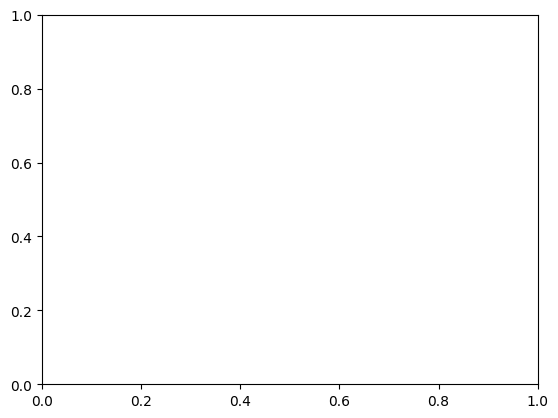

In [30]:
f = interp1d(
    _m_df["time"].dt.epoch(), _theta_y, kind="linear", fill_value="extrapolate"
)  # You can also use 'cubic' or other interpolation methods
_theta_y_1 = f(ar_df["time"].dt.epoch())
plt.scatter(_theta_y_1, _theta_y_0)
plt.plot([-60, 60], [-60, 60], "k")

In [ ]:
imu_df = _imu_df.clone()
cols = [
    "time",
    "ax",
    "ay",
    "az",
    "gx",
    "gy",
    "gz",
    "mx",
    "my",
    "mz",
    "ang_x",
    "ang_y",
    "ang_z",
]
imu_df = interpolate_target_df(imu_df, ar_df, cols)
imu_df = pl.from_pandas(imu_df)

In [ ]:
_imurmat_x = []
_imurmat_y = []
_imurmat_z = []
_i_theta = 0
for i in range(len(imu_df)):
    _i_theta = np.deg2rad(-imu_df["ang_z"][i] + imu_df["ang_z"][0])

    _imurmat_y.append(
        np.array(
            [
                [np.cos(_i_theta), 0, np.sin(_i_theta)],
                [0, 1, 0],
                [-np.sin(_i_theta), 0, np.cos(_i_theta)],
            ]
        )
    )

In [ ]:
_imu_dr = []

for i in range(len(imu_df)):
    _dr = rmat[0] @ _imurmat_y[i].T
    _dr = _dr.T
    _imu_dr.append(_dr)

In [ ]:
_mdf = _mocap_df.copy()
_cdf = ar_df.to_pandas()
_cols = []
for i in ["x", "y", "z"]:
    _cols.append(_om[i])
    _cols.append(_xm[i])
    _cols.append(_zm[i])
_cdf["time"] = pd.to_datetime(_cdf["time"])

In [ ]:
_mo_df = interpolate_target_df(_mdf, _cdf, _cols)
_mo_df = pl.from_pandas(_mo_df)

In [ ]:
# convert time to datetime format
if type(ar_df["time"][0]) != datetime:
    ar_df = ar_df.with_columns(pl.col("time").str.to_datetime())
if type(ar_df_49["time"][0]) != datetime:
    ar_df_49 = ar_df_49.with_columns(pl.col("time").str.to_datetime())
if type(ar_df_80["time"][0]) != datetime:
    ar_df_80 = ar_df_80.with_columns(pl.col("time").str.to_datetime())

Orthonormalizing rmat

Marker 0

In [ ]:
rA_m1_d = np.array([0.0, 0.02, -0.13]).reshape(3, 1)

In [ ]:
newdata = {"x": [], "y": [], "z": []}
for i in range(len(ar_df)):
    val = ar_df[["x", "y", "z"]][i].to_numpy().reshape(3, 1)
    pa_c = _imu_dr[i] @ rA_m1_d + val
    pa_b = _ar_lframe_rot.T @ (pa_c - _ar_lframe_org)
    val = pa_b
    if i == 0:
        initial = val
    if val is None:
        rval = np.nan
    else:
        rval = val

    reval = (rotMat.T @ (rval - translation_correction)).T[0]

    newdata["x"].append(reval[0])
    newdata["y"].append(reval[1])
    newdata["z"].append(reval[2])

In [ ]:
phi = np.pi / 2
positive_90_rotation = np.array(
    [[np.cos(phi), 0, np.sin(phi)], [0, 1, 0], [-np.sin(phi), 0, np.cos(phi)]]
)

negative_90_rotation = np.array(
    [[np.cos(-phi), 0, np.sin(-phi)], [0, 1, 0], [-np.sin(-phi), 0, np.cos(-phi)]]
)

negative_90_rotation

array([[ 6.123234e-17,  0.000000e+00, -1.000000e+00],
       [ 0.000000e+00,  1.000000e+00,  0.000000e+00],
       [ 1.000000e+00,  0.000000e+00,  6.123234e-17]])

Marker 49

In [ ]:
rA_m1_49 = np.array([-0.055, 0.0, -0.075]).reshape(3, 1)

In [ ]:
newdata_49 = {"x": [], "y": [], "z": []}
for i in range(len(ar_df)):
    val_49 = ar_df_49[["x", "y", "z"]][i].to_numpy().reshape(3, 1)
    pa_c = _imu_dr[i] @ positive_90_rotation @ rA_m1_49 + val_49
    pa_b = _ar_lframe_rot.T @ (pa_c - _ar_lframe_org)
    val_49 = pa_b

    if i == 0:
        initial = ar_df[["x", "y", "z"]][0].to_numpy().reshape(3, 1)
    if val_49 is None:
        rval_49 = np.nan
    else:
        rval_49 = val_49

    reval_49 = (rotMat.T @ (rval_49)).T[0]

    newdata_49["x"].append(reval_49[0])
    newdata_49["y"].append(reval_49[1])
    newdata_49["z"].append(reval_49[2])

Marker 80

In [ ]:
rA_m1_80 = np.array([0.055, 0.0, -0.075]).reshape(3, 1)

In [ ]:
newdata_80 = {"x": [], "y": [], "z": []}
for i in range(len(ar_df)):
    val_80 = ar_df_80[["x", "y", "z"]][i].to_numpy().reshape(3, 1)
    pa_c = _imu_dr[i] @ negative_90_rotation @ rA_m1_80 + val_80
    pa_b = _ar_lframe_rot.T @ (pa_c - _ar_lframe_org)
    val_80 = pa_b

    if i == 0:
        initial = ar_df[["x", "y", "z"]][0].to_numpy().reshape(3, 1)
    if val_80 is None:
        rval_80 = np.nan
    else:
        rval_80 = val_80

    reval_80 = (rotMat.T @ (rval_80)).T[0]

    newdata_80["x"].append(reval_80[0])
    newdata_80["y"].append(reval_80[1])
    newdata_80["z"].append(reval_80[2])

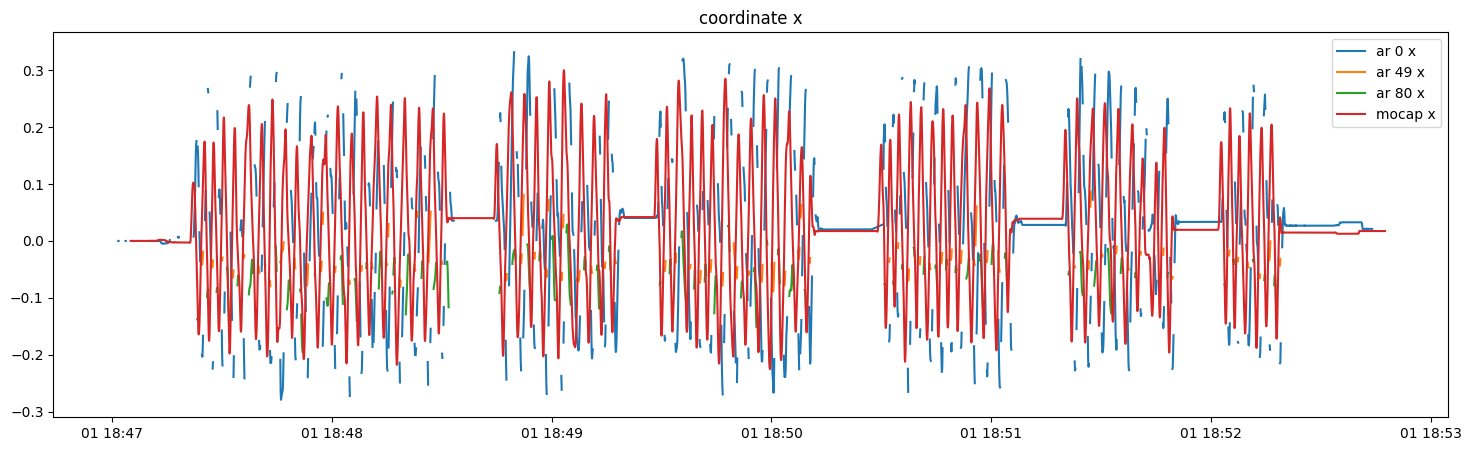

In [ ]:
fig, (ax0) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(18, 5))

ax0.plot(
    ar_df["time"], (np.array(newdata["x"]) - np.array(newdata["x"][0])), label="ar 0 x"
)
ax0.plot(ar_df["time"], np.array(newdata_49["x"]), label="ar 49 x")
ax0.plot(ar_df["time"], np.array(newdata_80["x"]), label="ar 80 x")
ax0.plot(_mc_df["time"], _mc_df["x"] - _mc_df["x"][0], label="mocap x")
# ax0.set_ylim(-0.3, 0.3)
ax0.set_title("coordinate x")
ax0.legend()

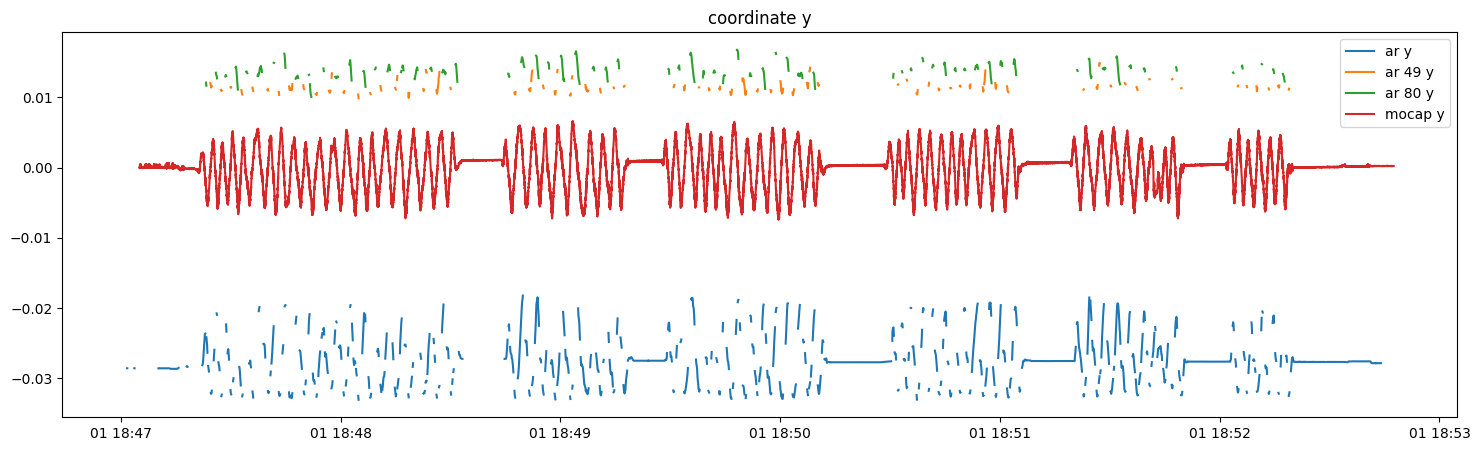

In [ ]:
fig, (ax0) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(18, 5))

ax0.plot(ar_df["time"], np.array(newdata["y"]) - 0.026, label="ar y")
ax0.plot(ar_df["time"], np.array(newdata_49["y"]) + 0.028, label="ar 49 y")
ax0.plot(ar_df["time"], np.array(newdata_80["y"]) + 0.032, label="ar 80 y")
ax0.plot(_mc_df["time"], _mc_df["y"] - _mc_df["y"][0], label="mocap y")
# ax0.set_ylim(-0.1, 0.1)
ax0.set_title("coordinate y")
ax0.legend()

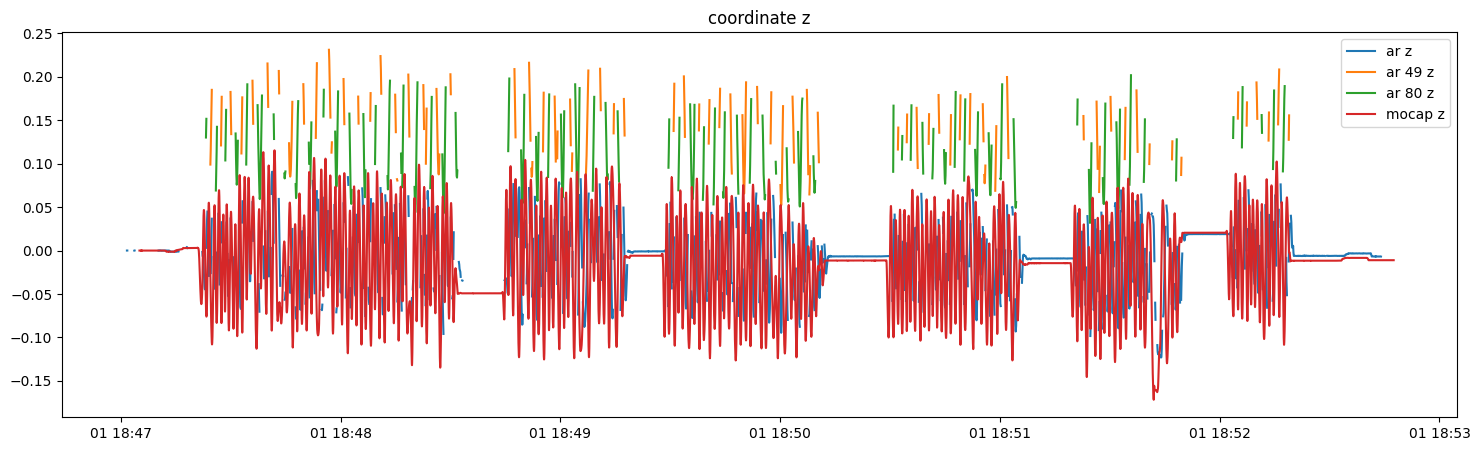

In [ ]:
fig, (ax0) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(18, 5))

ax0.plot(
    ar_df["time"], (np.array(newdata["z"]) - np.array(newdata["z"][0])), label="ar z"
)
ax0.plot(ar_df["time"], np.array(newdata_49["z"]) - 0.045, label="ar 49 z")
ax0.plot(ar_df["time"], np.array(newdata_80["z"]) - 0.045, label="ar 80 z")
ax0.plot(_mc_df["time"], _mc_df["z"] - _mc_df["z"][0], label="mocap z")

ax0.set_title("coordinate z")
ax0.legend()

Full plotting

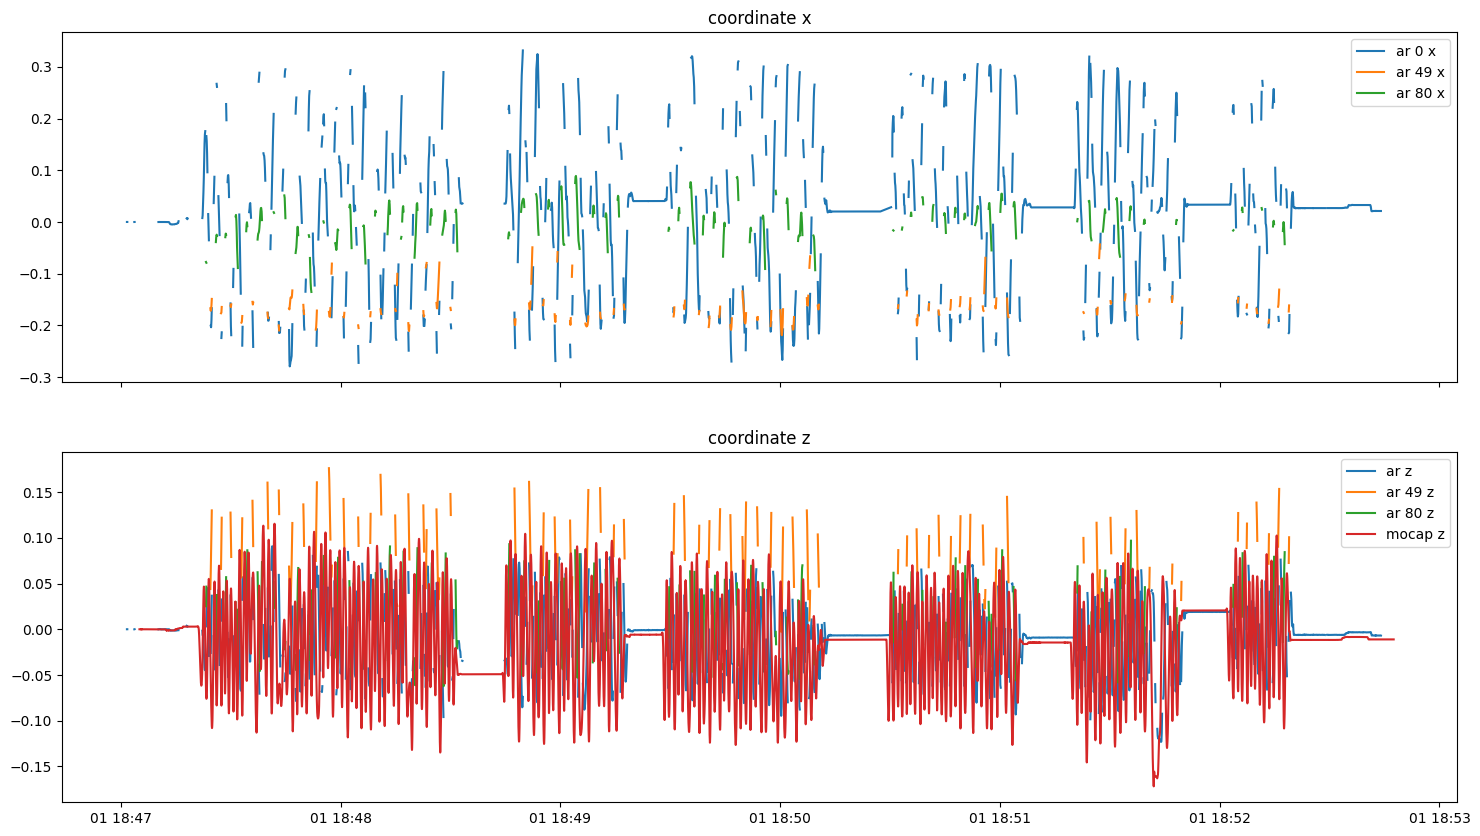

In [ ]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(18, 10))

ax0.plot(
    ar_df["time"], (np.array(newdata["x"]) - np.array(newdata["x"][0])), label="ar 0 x"
)
ax0.plot(ar_df["time"], np.array(newdata_49["x"]) - 0.13, label="ar 49 x")
ax0.plot(ar_df["time"], np.array(newdata_80["x"]) + 0.06, label="ar 80 x")
# ax0.plot(_mcc_df["time"],(_mcc_df['x'] - _mcc_df['x'][0]), label="mocap x")
ax0.set_title("coordinate x")
ax0.legend()

ax1.plot(
    ar_df["time"], (np.array(newdata["z"]) - np.array(newdata["z"][0])), label="ar z"
)
ax1.plot(ar_df["time"], np.array(newdata_49["z"]) - 0.1, label="ar 49 z")
ax1.plot(ar_df["time"], np.array(newdata_80["z"]) - 0.15, label="ar 80 z")
ax1.plot(_mc_df["time"], _mc_df["z"] - _mc_df["z"][0], label="mocap z")
ax1.set_title("coordinate z")
ax1.legend()

In [ ]:
validate = {"x": [], "y": [], "z": []}

for i in range(len(newdata["x"])):
    _val_0 = np.array(
        [newdata["x"][i] - newdata["x"][0], newdata["y"][i] - 0.026, newdata["z"][i]]
    )

    _val_1 = np.array(
        [
            newdata_49["x"][i] - 0.13,
            newdata_49["y"][i] + 0.028,
            newdata_49["z"][i] - 0.1,
        ]
    )

    _val_2 = np.array(
        [
            newdata_80["x"][i] + 0.06,
            newdata_80["y"][i] + 0.032,
            newdata_80["z"][i] - 0.15,
        ]
    )

    trigger = True

    if not np.isnan(_val_0).all() and trigger:
        validate["x"].append(_val_0[0])
        validate["y"].append(_val_0[1])
        validate["z"].append(_val_0[2])
        trigger = False
    elif not np.isnan(_val_1).all() and trigger:
        validate["x"].append(_val_1[0])
        validate["y"].append(_val_1[1])
        validate["z"].append(_val_1[2])
        trigger = False
    elif not np.isnan(_val_2).all() and trigger:
        validate["x"].append(_val_2[0])
        validate["y"].append(_val_2[1])
        validate["z"].append(_val_2[2])
        trigger = False
    else:
        validate["x"].append(np.nan)
        validate["y"].append(np.nan)
        validate["z"].append(np.nan)

In [ ]:
_mc_df

,time,x,y,z
0,2023-09-01 18:47:05.047,0.000000,0.000000,0.000000
1,2023-09-01 18:47:05.057,0.000004,0.000060,-0.000018
2,2023-09-01 18:47:05.067,0.000021,0.000030,-0.000012
3,2023-09-01 18:47:05.077,-0.000010,0.000034,-0.000006
4,2023-09-01 18:47:05.087,0.000006,0.000009,-0.000017
...,...,...,...,...
34242,2023-09-01 18:52:47.467,0.017400,0.000229,-0.011094
34243,2023-09-01 18:52:47.477,0.017392,0.000257,-0.011082
34244,2023-09-01 18:52:47.487,0.017394,0.000228,-0.011089
34245,2023-09-01 18:52:47.497,0.017380,0.000245,-0.011090


In [ ]:
_mcc_df = interpolate_target_df(_mc_df, _cdf, ["x", "y", "z"])
_mcc_df = pl.from_pandas(_mcc_df)

In [ ]:
_err_x = validate["x"] - (_mcc_df["x"] - _mcc_df["x"][0]).to_numpy()
_err_y = validate["y"] - (_mcc_df["y"] - _mcc_df["y"][0]).to_numpy()
_err_z = validate["z"] - (_mcc_df["z"] - _mcc_df["z"][0]).to_numpy()

In [ ]:
zscore_x = np.abs(stats.zscore(_err_x, nan_policy="omit"))
zscore_y = np.abs(stats.zscore(_err_y, nan_policy="omit"))
zscore_z = np.abs(stats.zscore(_err_z, nan_policy="omit"))
_zerr_x = _err_x[np.where(zscore_x < 2)]
_zerr_y = _err_y[np.where(zscore_y < 2)]
_zerr_z = _err_z[np.where(zscore_z < 2)]

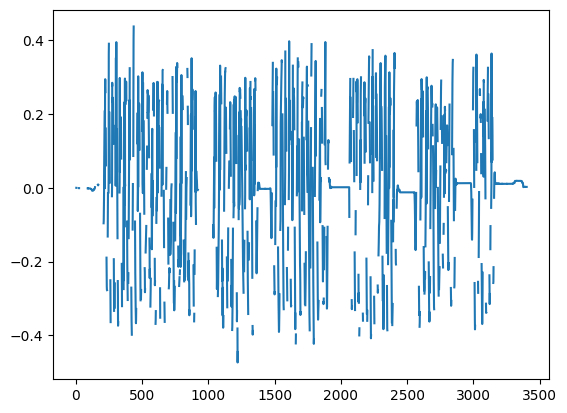

In [ ]:
plt.plot()
plt.plot(validate["x"] - (_mcc_df["x"] - _mcc_df["x"][0]).to_numpy())
# plt.plot(newdata['x'])

In [ ]:
print(np.nanmean(validate["x"] - (_mcc_df["x"] - _mcc_df["x"][0]).to_numpy()))
print(np.nanstd(validate["x"] - (_mcc_df["x"] - _mcc_df["x"][0]).to_numpy()))
print(np.nanmax(np.abs(validate["x"] - (_mcc_df["x"] - _mcc_df["x"][0]).to_numpy())))
print(np.nanmax(np.abs(_zerr_x)))

-0.0015572887878013218
0.1742704299522531
0.4730443347090706
0.3499362060218454


In [ ]:
print(np.nanmean(validate["y"] - (_mcc_df["y"] - _mcc_df["y"][0]).to_numpy()))
print(np.nanstd(validate["y"] - (_mcc_df["y"] - _mcc_df["y"][0]).to_numpy()))
print(np.nanmax(np.abs(validate["y"] - (_mcc_df["y"] - _mcc_df["y"][0]).to_numpy())))
print(np.nanmax(np.abs(_zerr_y)))

-0.04603259716356069
0.012888489658106341
0.06042581936505584
0.06042581936505584


In [ ]:
print(np.nanmean(validate["z"] - (_mcc_df["z"] - _mcc_df["z"][0]).to_numpy()))
print(np.nanstd(validate["z"] - (_mcc_df["z"] - _mcc_df["z"][0]).to_numpy()))
print(np.nanmax(np.abs(validate["z"] - (_mcc_df["z"] - _mcc_df["z"][0]).to_numpy())))
print(np.nanmax(_zerr_z))

0.1049190313529948
0.06616881363841796
0.3104714283072259
0.23723031956206633


In [ ]:
# Count total number of elements in the array
total_elements = np.size(validate["z"])
# Count the number of NaN values in the array
nan_count = np.count_nonzero(np.isnan(validate["z"]))

# Calculate the percentage of NaN values
percentage_nan = (nan_count / total_elements) * 100

print(f"Percentage of NaN values: {percentage_nan:.2f}%")

Percentage of NaN values: 33.03%
